In [29]:
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fft
from scipy import signal as sig
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
def pickle_file(obj, path):
    file = open(path, 'wb')
    pickle.dump(obj, file)
    file.close()

def load_pickle(path):
    file = open(path, 'rb')
    obj = pickle.load(file)
    file.close()
    return obj

In [114]:
df = load_pickle('./data_merged/mta_broughs_cases')
df['WEEK_YEAR']= pd.to_datetime(df["DATE"].dt.strftime('%Y-%m'))
borough_dict = {'Bk': 'Brooklyn', 'Bx': 'Bronx', 'M': 'Manhattan', 'Q': 'Queens'}
df.head()

,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,Bk_DAILY_ENTRIES,Bx_DAILY_ENTRIES,M_DAILY_ENTRIES,Q_DAILY_ENTRIES,SI_DAILY_ENTRIES,Bk_DAILY_EXITS,...,probable_case_count,HOSPITALIZED_COUNT,DEATH_COUNT,DEATH_COUNT_PROBABLE,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,all_death_count_7day_avg,WEEK_YEAR
0,2020-02-29,1.098717e+07,1.014809e+07,6.651748e+06,1592354.0,472832.000000,8.103800e+06,8.138530e+05,4332.0,1300999.0,...,0,1,0,0,0,0,0,0,0,2020-02-01
1,2020-03-01,8.332771e+06,7.565224e+06,5.075832e+06,1202466.0,357483.000000,6.120865e+06,6.487580e+05,3199.0,1042235.0,...,0,1,0,0,0,0,0,0,0,2020-03-01
2,2020-03-02,2.107111e+07,1.813919e+07,1.258845e+07,2878680.0,877654.000000,1.571191e+07,1.575667e+06,27196.0,2171576.0,...,0,2,0,0,0,0,0,0,0,2020-03-01
3,2020-03-03,2.175668e+07,1.880443e+07,1.302943e+07,2940052.0,882679.553641,1.626314e+07,1.642746e+06,28062.0,2210979.0,...,0,7,0,0,0,0,0,0,0,2020-03-01
4,2020-03-04,2.183703e+07,1.891770e+07,1.302833e+07,2971407.0,892522.000000,1.629358e+07,1.652106e+06,27421.0,2264144.0,...,0,2,0,0,0,0,0,0,0,2020-03-01


In [115]:
df = df[df.DATE >= '2020-04-01']
df['HOURS_ELAPSE'] = (df.DATE - pd.to_datetime('2020-04-01')).astype('timedelta64[h]')
df.head()

,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,Bk_DAILY_ENTRIES,Bx_DAILY_ENTRIES,M_DAILY_ENTRIES,Q_DAILY_ENTRIES,SI_DAILY_ENTRIES,Bk_DAILY_EXITS,...,HOSPITALIZED_COUNT,DEATH_COUNT,DEATH_COUNT_PROBABLE,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,all_death_count_7day_avg,WEEK_YEAR,HOURS_ELAPSE
32,2020-04-01,1.686953e+06,1.794433e+06,1.318275e+06,316472.0,170041.0,1030117.0,168759.000000,1564.0,318263.0,...,1738,447,102,4891,4959,1622,303,370,2020-04-01,0.0
33,2020-04-02,1.596632e+06,1.713925e+06,1.250397e+06,298749.0,162504.0,975503.0,157973.000000,1903.0,303825.0,...,1662,497,169,4991,5078,1641,347,433,2020-04-01,24.0
34,2020-04-03,1.586761e+06,1.726531e+06,1.247653e+06,299674.0,160949.0,965804.0,158440.000000,1894.0,307622.0,...,1703,499,168,5070,5174,1660,388,491,2020-04-01,48.0
35,2020-04-04,9.091388e+05,1.098592e+06,7.648630e+05,177679.0,100147.0,537396.0,93006.817941,910.0,205767.0,...,1441,510,188,5125,5249,1668,422,545,2020-04-01,72.0
36,2020-04-05,7.265420e+05,9.218920e+05,6.324327e+05,147710.0,78780.0,425302.0,73970.000000,780.0,172433.0,...,1395,578,173,5157,5296,1653,463,602,2020-04-01,96.0


In [117]:


# time_sec is the hourly timestamp converted to seconds
X2 = pd.DataFrame(df[['HOURS_ELAPSE','HOSP_COUNT_7DAY_AVG']]) 
X1 = pd.DataFrame(df[['HOURS_ELAPSE']]) 
# signal is how many calls were made in that hour
y = pd.DataFrame(df.DAILY_EXITS) 

model1 = LinearRegression()
model1.fit(X1, y) 
df['pred_exits_linreg_date'] = model1.predict(X1)
df['residuals1'] = df.DAILY_EXITS - df.pred_exits_linreg_date

model2 = LinearRegression()
model2.fit(X2, y) 
df['pred_exits_linreg_date_hosp'] = model2.predict(X2)
df['residuals2'] = df.DAILY_EXITS - df.pred_exits_linreg_date_hosp

# time = data['time']
# residuals = data['residuals']

df.head()
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model1.coef_[0,0], model1.intercept_[0]))
print('R-squared: {:.2e}'.format(model1.score(X1,y)))

print('\n')
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model2.coef_[0,0], model2.intercept_[0]))
print('R-squared: {:.2e}'.format(model2.score(X2,y)))

Slope: 4.77e+02, Intercept: 2118039.07
R-squared: 6.94e-01


Slope: 4.62e+02, Intercept: 2610895.32
R-squared: 7.24e-01


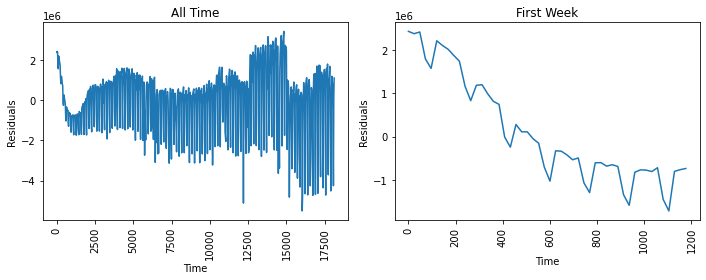

In [118]:
## Plot residuals in the time domain
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(df.HOURS_ELAPSE, df.residuals2, label='residuals')
ax1.set_title('All Time')
ax1.set_ylabel( 'Residuals' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 50

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(df.HOURS_ELAPSE[:N], df.residuals2[:N])
ax2.set_title('First Week')
ax2.set_ylabel( 'Residuals' )
ax2.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

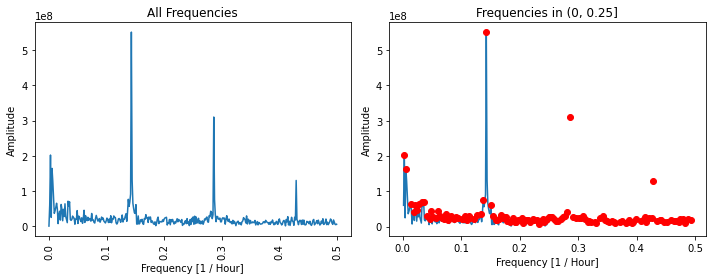

In [119]:
time = df.HOURS_ELAPSE
residuals = np.array(df.residuals2)

# Plotting power in the frequency domain
fft_output = fft.fft(residuals)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='residuals')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()

In [120]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq 
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)
output

,index,freq (1/hour),amplitude,period (days),fft
34,108,0.142857,5.514012e+08,7.000000,5.378035e+08-1.216992e+08j
75,216,0.285714,3.100263e+08,3.500000,-2.820997e+08+1.285926e+08j
0,2,0.002646,2.019228e+08,378.000000,-1.941676e+08-5.542336e+07j
1,4,0.005291,1.640286e+08,189.000000,1.624319e+08-2.283111e+07j
109,324,0.428571,1.297338e+08,2.333333,1.065030e+08-7.408082e+07j
...,...,...,...,...,...
97,289,0.382275,1.031914e+07,2.615917,8.911838e+06+5.202278e+06j
86,250,0.330688,9.789484e+06,3.024000,-8.084094e+06-5.520999e+06j
51,156,0.206349,9.467213e+06,4.846154,6.855631e+06+6.529047e+06j
100,296,0.391534,9.396358e+06,2.554054,5.699524e+06-7.470406e+06j


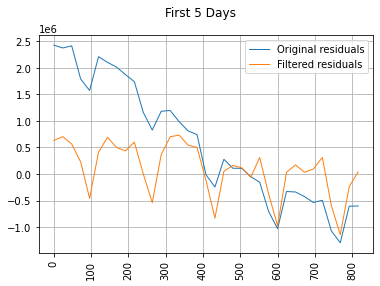

In [121]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_residuals = fft.ifft(filtered_fft_output)

N = 35
plt.plot(time[:N], residuals[:N], linewidth=1, label='Original residuals')
plt.plot(time[:N], filtered_residuals[:N].real, linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
# plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

In [122]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq (1 / hour)'] = output['freq (1/hour)']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq (1 / hour),amplitude,phase
label,,,,
FT_1,5.378035e+08-1.216992e+08j,0.142857,5.514012e+08,-0.222541
FT_2,-2.820997e+08+1.285926e+08j,0.285714,3.100263e+08,2.713892
FT_3,-1.941676e+08-5.542336e+07j,0.002646,2.019228e+08,-2.863546
FT_4,1.624319e+08-2.283111e+07j,0.005291,1.640286e+08,-0.139643
FT_5,1.065030e+08-7.408082e+07j,0.428571,1.297338e+08,-0.607750
...,...,...,...,...
FT_120,8.911838e+06+5.202278e+06j,0.382275,1.031914e+07,0.528385
FT_121,-8.084094e+06-5.520999e+06j,0.330688,9.789484e+06,-2.542404
FT_122,6.855631e+06+6.529047e+06j,0.206349,9.467213e+06,0.761003


In [123]:
def ft_function(df):
    data = df
    for key in fourier_terms_dict.keys():
        a = fourier_terms_dict[key]['amplitude']
        w = 2 * math.pi * (fourier_terms_dict[key]['freq (1 / hour)'] / 24)
        p = fourier_terms_dict[key]['phase']
        data[key] = data.HOURS_ELAPSE.apply(lambda t: a * math.cos(w*t + p))

    data['FT_All'] = 0
    for column in list(fourier_terms.index):
        data['FT_All'] = data['FT_All'] + data[column]


    # Sample 
    data[['DAILY_EXITS', 'HOURS_ELAPSE', 'FT_All']  + list(fourier_terms.index)]
    return data

data = ft_function(df)
data

/tmp/ipykernel_25804/656256163.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_25804/656256163.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_25804/656256163.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_25804/656256163.py:7: PerformanceWarn

,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,Bk_DAILY_ENTRIES,Bx_DAILY_ENTRIES,M_DAILY_ENTRIES,Q_DAILY_ENTRIES,SI_DAILY_ENTRIES,Bk_DAILY_EXITS,...,FT_116,FT_117,FT_118,FT_119,FT_120,FT_121,FT_122,FT_123,FT_124,FT_All
32,2020-04-01,1.686953e+06,1.794433e+06,1.318275e+06,316472.0,170041.0,1.030117e+06,168759.000000,1564.0,318263.0,...,-1.155953e+07,-1.136246e+07,1.037812e+07,7.837123e+06,8.911838e+06,-8.084094e+06,6.855631e+06,5.699524e+06,4.011860e+06,4.783098e+08
33,2020-04-02,1.596632e+06,1.713925e+06,1.250397e+06,298749.0,162504.0,9.755030e+05,157973.000000,1903.0,303825.0,...,4.449701e+06,2.191068e+06,-9.847401e+06,2.963941e+05,-1.008962e+07,8.751670e+06,-4.428236e+06,2.797225e+05,-3.919810e+06,5.324134e+08
34,2020-04-03,1.586761e+06,1.726531e+06,1.247653e+06,299674.0,160949.0,9.658040e+05,158440.000000,1894.0,307622.0,...,6.186028e+06,1.158090e+07,9.201834e+06,-8.225655e+06,5.994157e+06,-4.144136e+05,-9.254322e+06,-6.134002e+06,-4.857238e+06,4.272793e+08
35,2020-04-04,9.091388e+05,1.098592e+06,7.648630e+05,177679.0,100147.0,5.373960e+05,93006.817941,910.0,205767.0,...,-1.192000e+07,-1.036548e+06,-8.448954e+06,1.048631e+07,1.234102e+06,-8.349244e+06,-5.846540e+05,9.247887e+06,2.872258e+06,1.722736e+08
36,2020-04-05,7.265420e+05,9.218920e+05,6.324327e+05,147710.0,78780.0,4.253020e+05,73970.000000,780.0,172433.0,...,8.208672e+06,-1.168423e+07,7.597541e+06,-5.520467e+06,-7.817369e+06,8.522136e+06,8.937627e+06,-8.230235e+06,5.476693e+06,-3.450975e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,2022-04-22,8.157979e+06,1.156987e+07,6.422665e+06,1083884.0,460308.0,5.890191e+06,714431.000000,9165.0,1384606.0,...,-4.309052e+06,-5.479270e+06,-1.114293e+07,9.814870e+06,4.816057e+06,9.144945e+06,8.013407e+06,7.462592e+06,5.817913e+06,9.661557e+07
784,2022-04-23,5.376843e+06,8.727550e+06,4.317266e+06,701162.0,295079.0,3.907754e+06,472752.000000,96.0,1099084.0,...,1.151860e+07,-1.059012e+07,1.125030e+07,-9.532139e+06,-9.709197e+06,-1.386198e+06,-2.682402e+06,-2.198669e+06,1.809295e+06,-8.900206e+08
785,2022-04-24,4.124192e+06,6.609731e+06,3.382413e+06,582074.0,239787.0,2.930571e+06,371736.000000,24.0,913898.0,...,-9.600916e+06,4.423523e+06,-1.122646e+07,2.680459e+06,9.527912e+06,-7.798846e+06,-9.466413e+06,-4.047520e+06,-5.427706e+06,-1.611141e+09
786,2022-04-25,8.228198e+06,1.101961e+07,6.510174e+06,1257432.0,416974.0,5.766384e+06,776348.000000,11060.0,1548209.0,...,7.554665e+04,1.103111e+07,1.107170e+07,6.018424e+06,-4.366949e+06,8.959445e+06,-2.445373e+06,8.485460e+06,-2.979879e+06,-2.302361e+08


In [124]:
df['WEEKDAY'] = df.DATE.dt.day_of_week
df['WEEKDAY'][df.WEEKDAY <=4 ] =  1 
df['WEEKDAY'][df.WEEKDAY > 1  ] = 0 

/tmp/ipykernel_25804/2935434660.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_25804/2935434660.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [126]:
# time_sec is the hourly timestamp converted to seconds
# list(fourier_terms.index) are the names of our Fourier terms
# X = pd.DataFrame(data[['time_sec'] + list(fourier_terms.index)]) 
X = pd.DataFrame(data[['HOURS_ELAPSE', 'FT_All', 'HOSPITALIZED_COUNT']]) 
# signal is how many calls were made in that hour
y = pd.DataFrame(data['DAILY_EXITS']) 

model = LinearRegression()
model.fit(X, y)

df['y_pred'] = model.predict(X)

df.head()
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model1.coef_[0,0], model1.intercept_[0]))
print('R-squared: {:.2e}'.format(model1.score(X1,y)))

print('\n')
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model2.coef_[0,0], model2.intercept_[0]))
print('R-squared: {:.2e}'.format(model2.score(X2,y)))

print('\n')
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(X,y)))

df.head()
# N = 7 * 10

# plt.plot(X['HOURS_ELAPSE'][:N], y[:N], linewidth=1, label='Original Signal')
# plt.plot(X['HOURS_ELAPSE'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
# plt.legend(loc='upper right')
# plt.suptitle('First 5 Days')
# plt.grid()
# plt.xticks(rotation=90)

Slope: 4.77e+02, Intercept: 2118039.07
R-squared: 6.94e-01


Slope: 4.62e+02, Intercept: 2610895.32
R-squared: 7.24e-01


Slope: 4.84e+02, Intercept: 2358658.14
R-squared: 9.48e-01


,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,Bk_DAILY_ENTRIES,Bx_DAILY_ENTRIES,M_DAILY_ENTRIES,Q_DAILY_ENTRIES,SI_DAILY_ENTRIES,Bk_DAILY_EXITS,...,FT_118,FT_119,FT_120,FT_121,FT_122,FT_123,FT_124,FT_All,WEEKDAY,y_pred
32,2020-04-01,1.686953e+06,1.794433e+06,1.318275e+06,316472.0,170041.0,1030117.0,168759.000000,1564.0,318263.0,...,1.037812e+07,7.837123e+06,8.911838e+06,-8.084094e+06,6.855631e+06,5.699524e+06,4.011860e+06,4.783098e+08,1,5.654499e+05
33,2020-04-02,1.596632e+06,1.713925e+06,1.250397e+06,298749.0,162504.0,975503.0,157973.000000,1903.0,303825.0,...,-9.847401e+06,2.963941e+05,-1.008962e+07,8.751670e+06,-4.428236e+06,2.797225e+05,-3.919810e+06,5.324134e+08,1,8.578264e+05
34,2020-04-03,1.586761e+06,1.726531e+06,1.247653e+06,299674.0,160949.0,965804.0,158440.000000,1894.0,307622.0,...,9.201834e+06,-8.225655e+06,5.994157e+06,-4.144136e+05,-9.254322e+06,-6.134002e+06,-4.857238e+06,4.272793e+08,1,5.131556e+05
35,2020-04-04,9.091388e+05,1.098592e+06,7.648630e+05,177679.0,100147.0,537396.0,93006.817941,910.0,205767.0,...,-8.448954e+06,1.048631e+07,1.234102e+06,-8.349244e+06,-5.846540e+05,9.247887e+06,2.872258e+06,1.722736e+08,0,3.017939e+05
36,2020-04-05,7.265420e+05,9.218920e+05,6.324327e+05,147710.0,78780.0,425302.0,73970.000000,780.0,172433.0,...,7.597541e+06,-5.520467e+06,-7.817369e+06,8.522136e+06,8.937627e+06,-8.230235e+06,5.476693e+06,-3.450975e+08,0,-1.000394e+06


In [95]:
# from sklearn.neural_network import MLPRegressor

# X = pd.DataFrame(data[['HOURS_ELAPSE', 'FT_All', 'HOSP_COUNT_7DAY_AVG']]) 

# y = pd.DataFrame(np.array(data['DAILY_EXITS'])) 

# model = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
# model.fit(X, y)

# df['y_pred'] = model.predict(X)

# df.head()

/home/patrick/anaconda3/envs/metis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,Bk_DAILY_ENTRIES,Bx_DAILY_ENTRIES,M_DAILY_ENTRIES,Q_DAILY_ENTRIES,SI_DAILY_ENTRIES,Bk_DAILY_EXITS,...,FT_122,FT_123,FT_124,FT_125,FT_126,FT_127,FT_128,FT_129,FT_All,y_pred
33,2020-04-02,1.596632e+06,1.713925e+06,1.250397e+06,298749.0,162504.0,975503.0,157973.000000,1903.0,303825.0,...,-8.731966e+06,-9.796009e+06,-9.297307e+06,8.424887e+06,-8.172796e+06,-4.494231e+06,5.876926e+06,2.629425e+06,4.667247e+07,6.047528e+05
34,2020-04-03,1.586761e+06,1.726531e+06,1.247653e+06,299674.0,160949.0,965804.0,158440.000000,1894.0,307622.0,...,3.589697e+06,6.341567e+06,5.051043e+06,-3.461950e+06,7.986275e+06,5.241023e+06,-5.883546e+06,-2.925663e+06,-1.471361e+08,1.080909e+06
35,2020-04-04,9.091388e+05,1.098592e+06,7.648630e+05,177679.0,100147.0,537396.0,93006.817941,910.0,205767.0,...,3.030870e+06,3.295169e+05,2.653014e+06,-3.784761e+06,-7.726661e+06,-5.787998e+06,5.889248e+06,2.995975e+06,-7.513168e+08,5.520444e+06
36,2020-04-05,7.265420e+05,9.218920e+05,6.324327e+05,147710.0,78780.0,425302.0,73970.000000,780.0,172433.0,...,-8.403273e+06,-6.833459e+06,-8.540897e+06,8.534746e+06,7.396330e+06,6.114302e+06,-5.894034e+06,-2.834933e+06,-3.135017e+08,2.303378e+06
37,2020-04-06,1.452065e+06,1.602532e+06,1.161920e+06,276593.0,147944.0,879644.0,146083.000000,1801.0,283357.0,...,1.031507e+07,9.871258e+06,8.581936e+06,-7.654543e+06,-6.998306e+06,-6.207494e+06,5.897900e+06,2.454971e+06,-1.414373e+07,1.036974e+05


In [23]:
def generate_figure(df, columns):
    # df = df[df.DATE.dt.weekday > 4]
    df = df.groupby('WEEK_YEAR').mean().reset_index()
    df['DATE'] = df.WEEK_YEAR
    # df = df[df.TIME_OF_WEEK == 'Weekend']
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    #               yaxis_domain=[0, 0.94])

    fig.add_trace(go.Scatter(x=df.DATE, y=df.HOSP_COUNT_7DAY_AVG,
                        mode='lines',
                        name='Hospitalized',
                        opacity = .8))
    for col in columns:
        fig.add_trace(go.Scatter(x=df.DATE, y=df[col],
                            mode='lines',
                            name=borough_dict[col.split('_')[0]],
                            opacity = .35),
                            secondary_y = True)
    # fig.data[1].update(xaxis='x2')
    fig.update_yaxes(title_text="Hospitalized", secondary_y=False)
    fig.update_yaxes(title_text="Subway Traffic", secondary_y=True)
    fig.update_layout(title='Average Weekly Subway Use and Rates of Covid Hospitalization')
    
    return fig
fig = generate_figure(df, ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY','Q_LINE_DENSITY'])
fig.write_html("./images/Weekly_Subway_Use_By_Borough.html")
fig.show()
# generate_figure(df, ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'Q_LINE_DENSITY']).show()

In [ ]:

# plt.figure(figsize=(4,12))

fig, ax = plt.subplots(figsize=(12,4))


# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
# axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Red', 'Blue')
i=0
# df = df[df.DAILY_ENTRIES<1000000]
for ax, color in zip(axes, colors):
    if i ==0 :
        ax.plot(df.DATE,df.DAILY_EXITS, color=color)
        ax.set_ylabel('Daily Exits')
    else: 
        ax.plot(df.DATE,df.CASE_COUNT, color=color)
        ax.set_ylabel('Daily Cases')
    # ax.set_ylabel('%s Thing' % color, color=color)
    ax.tick_params(axis='y', colors=color)
    i+= 1
axes[0].set_xlabel('Date')


plt.show()

In [21]:
# df1 = df.melt(id_vars=['DATE']+list(df.keys()[5:]), var_name='Subway')
df['DAY_OF_WEEK'] = df.DATE.dt.day_name()
df['TIME_OF_WEEK'] = df.DATE.dt.weekday.replace([0,1,2,3,4],'Weekday').replace([5,6],'Weekend')
fig = px.line(df, x='DATE', y='DAILY_EXITS', color='TIME_OF_WEEK' )
# fig.add_trace()
fig.show()

In [168]:
# Create traces
# fig = go.Figure()

def generate_figure(df):
    # df = df[df.TIME_OF_WEEK == 'Weekend']
    fig = make_subplots(
                        # cols=1,
                        # rows=4,
                        # specs=[[{}, {}],[{"colspan": 2}, None]]
                        )
    
    # fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    #               yaxis_domain=[0, 0.94])
    

    fig.add_trace(go.Scatter(x=df.DATE, y=df.pred_exits_linreg_date_hosp,
                        mode='lines',
                        # name='Prediction (Date, Hospitalized)',
                        opacity = .8,
                        line=dict(width=1),
                        legendgroup="1",  # this can be any string, not just "group"
                        legendgrouptitle_text="Prediction (R-squared: 6.94e-01)",
                        name="Date, Hospitalized"),
                        # row = 1,
                        # col = 1
                        )
    fig.add_trace(go.Scatter(x=df.DATE, y=df.pred_exits_linreg_date,
                        mode='lines',
                        # name='Prediction (Date)',
                        opacity = .8,
                        line=dict(width=1),
                        legendgroup="2",  # this can be any string, not just "group"
                        legendgrouptitle_text="Prediction (R-squared: 7.24e-01)",
                        name="Date"),
                        # row = 2,
                        # col = 1
                        )
    fig.add_trace(go.Scatter(x=df.DATE, y=df.y_pred,
                        mode='lines',
                        # name='Prediction (Date, Hospitalized, Fourier)',
                        opacity = .8,
                        line=dict(width=1),
                        legendgroup="3",  # this can be any string, not just "group"
                        legendgrouptitle_text="Prediction (R-squared: 9.48e-01)",
                        name="Date, Hospitalized, Fourier"),
                        # row = 3,
                        # col = 1
                        )
    fig.add_trace(go.Scatter(x=df.DATE, y=df.DAILY_EXITS,
                        mode='lines',
                        # name='Actual',
                        opacity = .4,
                        line=dict(color='firebrick', width=1),
                        legendgroup="4",  # this can be any string, not just "group"
                        legendgrouptitle_text="Actual Subway Traffic",
                        name="Ground-Truth"),
                        # row = 4,
                        # col = 1
                        )

    # fig.data[1].update(xaxis='x2')
    # fig.update_yaxes(title_text="Predicted")
    # fig.update_yaxes(title_text="Actual")
    # fig.update_layout(legend_title_text='Subway Use')
    fig.update_layout(title='Predicting Subway Use Post New York City Stay At Home Order')
    fig.write_html("./images/subway_use_regression_date_hosp_with_fourier.html")
    
    return fig
generate_figure(df).show()

In [8]:
df.columns

Index(['DATE', 'DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY',
       'Bk_DAILY_ENTRIES', 'Bx_DAILY_ENTRIES', 'M_DAILY_ENTRIES',
       'Q_DAILY_ENTRIES', 'SI_DAILY_ENTRIES', 'Bk_DAILY_EXITS',
       'Bx_DAILY_EXITS', 'M_DAILY_EXITS', 'Q_DAILY_EXITS', 'SI_DAILY_EXITS',
       'Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY',
       'Q_LINE_DENSITY', 'SI_LINE_DENSITY', 'DATE_OF_INTEREST', 'CASE_COUNT',
       'probable_case_count', 'HOSPITALIZED_COUNT', 'DEATH_COUNT',
       'DEATH_COUNT_PROBABLE', 'CASE_COUNT_7DAY_AVG',
       'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
       'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg'],
      dtype='object')

In [15]:

def generate_corr_table(full_df):
    corr_table = []
    rows = ['DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY']
    columns = ['CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT', 
        'CASE_COUNT_7DAY_AVG', 'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
        'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg']
    masks = ['Daily', 'Weekday', 'Weekend']

    full_df['TIME_OF_WEEK'] = full_df.DATE.dt.weekday.replace([0,1,2,3,4],'Weekday').replace([5,6],'Weekend')
    for mask in masks:
        if mask == 'Weekday':
            df = full_df[full_df.TIME_OF_WEEK == 'Weekday']
        elif mask == 'Weekend':
            df = full_df[full_df.TIME_OF_WEEK == 'Weekend']
        else:
            df = full_df
        for row in rows:
            dict_to_add = {'Mask':mask ,'Correlate':row}
            for column in columns:
                dict_to_add[column] = df[row].corr(df[column])
            corr_table.append(dict_to_add)
    return corr_table

def generate_corr_table_2(full_df):
    corr_table = []
    # rows = ['DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY']
    rows = ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY',
       'Q_LINE_DENSITY', 'SI_LINE_DENSITY']
    columns = ['CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT', 
        'CASE_COUNT_7DAY_AVG', 'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
        'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg']

    df = full_df
    for row in rows:
        dict_to_add = {'Correlate':row}
        for column in columns:
            dict_to_add[column] = df[row].corr(df[column])
        corr_table.append(dict_to_add)
    return corr_table
corr_table = pd.DataFrame(generate_corr_table_2(df))
# corr_table.to_csv('./tables/correlation_table_time_of_week.csv')
corr_table.head()


,Correlate,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,all_death_count_7day_avg
0,Bk_LINE_DENSITY,0.029814,-0.301112,-0.412242,-0.043991,-0.036477,-0.343780,-0.418453,-0.409800
1,Bx_LINE_DENSITY,0.024843,-0.267438,-0.380951,-0.063265,-0.055679,-0.320002,-0.388803,-0.381172
2,M_LINE_DENSITY,0.041330,-0.289087,-0.388085,-0.022554,-0.016779,-0.326264,-0.392899,-0.381997
3,Q_LINE_DENSITY,0.048379,-0.309094,-0.438308,-0.028372,-0.019813,-0.355223,-0.445171,-0.435980
4,SI_LINE_DENSITY,0.047977,-0.187201,-0.277484,-0.033027,-0.029996,-0.233598,-0.284945,-0.276426


In [121]:
# corr_table.groupby(['Mask']).max()
corr_table = corr_table.round(3)
corr_table.set_index(['Correlate'], inplace=True)

# corr_table.to_markdown('./tables/correlation_table_time_of_week.md')
corr_table.head()

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,all_death_count_7day_avg
Correlate,,,,,,,,
DAILY_ENTRIES,0.019,-0.287,-0.392,-0.055,-0.049,-0.332,-0.399,-0.388
DAILY_EXITS,0.052,-0.305,-0.414,-0.013,-0.006,-0.342,-0.418,-0.409
LINE_DENSITY,0.035,-0.299,-0.408,-0.037,-0.030,-0.341,-0.414,-0.404


In [74]:
corr_table.abs().sort_values(('Daily', 'LINE_DENSITY'),axis=1, ascending=False)

DEATH_COUNT_7DAY_AVG  DEATH_COUNT  \
Mask    Correlate                                          
Daily   DAILY_ENTRIES                 0.399        0.392   
        DAILY_EXITS                   0.418        0.414   
        LINE_DENSITY                  0.414        0.408   
Weekday DAILY_ENTRIES                 0.463        0.458   
        DAILY_EXITS                   0.466        0.463   
        LINE_DENSITY                  0.478        0.474   
Weekend DAILY_ENTRIES                 0.488        0.481   
        DAILY_EXITS                   0.472        0.468   
        LINE_DENSITY                  0.497        0.492   

                       all_death_count_7day_avg  HOSP_COUNT_7DAY_AVG  \
Mask    Correlate                                                      
Daily   DAILY_ENTRIES                     0.388                0.332   
        DAILY_EXITS                       0.409                0.342   
        LINE_DENSITY                      0.404                0.341   
Weekday DAILY_ENTRIES                     0.451                0.382   
        DAILY_EXITS                       0.456                0.378   
        LINE_DENSITY                      0.467                0.391   
Weekend DAILY_ENTRIES                     0.473                0.421   
        DAILY_EXITS                       0.459                0.397   
        LINE_DENSITY                      0.483                0.424   

                       HOSPITALIZED_COUNT  CASE_COUNT_7DAY_AVG  CASE_COUNT  \
Mask    Correlate                                                            
Daily   DAILY_ENTRIES               0.287                0.055       0.019   
        DAILY_EXITS                 0.305                0.013       0.052   
        LINE_DENSITY                0.299                0.037       0.035   
Weekday DAILY_ENTRIES               0.357                0.056       0.028   
        DAILY_EXITS                 0.361                0.007       0.017   
        LINE_DENSITY                0.370                0.034       0.009   
Weekend DAILY_ENTRIES               0.382                0.110       0.088   
        DAILY_EXITS                 0.368                0.046       0.036   
        LINE_DENSITY                0.390                0.082       0.067   

                       all_case_count_7day_avg  
Mask    Correlate                               
Daily   DAILY_ENTRIES                    0.049  
        DAILY_EXITS                      0.006  
        LINE_DENSITY                     0.030  
Weekday DAILY_ENTRIES                    0.048  
        DAILY_EXITS                      0.001  
        LINE_DENSITY                     0.027  
Weekend DAILY_ENTRIES                    0.101  
        DAILY_EXITS                      0.037  
        LINE_DENSITY                     0.073

In [29]:
print(f'Correlation between Subway Entries and Covid Cases:\t{df.DAILY_ENTRIES.corr(df.HOSP_COUNT_7DAY_AVG)}')
print(f'Correlation between Subway Exits and Covid Cases:\t{df.DAILY_EXITS.corr(df.HOSP_COUNT_7DAY_AVG)}')
print(f'Correlation between Line Density and Covid Cases:\t{df.LINE_DENSITY.corr(df.HOSP_COUNT_7DAY_AVG)}')

Correlation between Subway Entries and Covid Cases:	-0.4210110108217203
Correlation between Subway Exits and Covid Cases:	-0.3974747024305076
Correlation between Line Density and Covid Cases:	-0.42385720942325505


In [22]:
df = df[df.TIME_OF_WEEK == 'Weekend']

In [27]:
for x in range(-14,0):
    print(f'Correlation between Line Density and Covid Cases {-x} days later:\t{df.DAILY_EXITS.shift(x).corr(df.CASE_COUNT.iloc[:x])}')

Correlation between Line Density and Covid Cases 14 days later:	0.0770438946965025
Correlation between Line Density and Covid Cases 13 days later:	0.11008927080244933
Correlation between Line Density and Covid Cases 12 days later:	0.04216675584115764
Correlation between Line Density and Covid Cases 11 days later:	0.08459921553077798
Correlation between Line Density and Covid Cases 10 days later:	0.0277357720267018
Correlation between Line Density and Covid Cases 9 days later:	0.030059785495632107
Correlation between Line Density and Covid Cases 8 days later:	-0.008630599965366697
Correlation between Line Density and Covid Cases 7 days later:	-0.020227781505678662
Correlation between Line Density and Covid Cases 6 days later:	-0.03774931143740905
Correlation between Line Density and Covid Cases 5 days later:	-0.013752864111256443
Correlation between Line Density and Covid Cases 4 days later:	-0.05333670330824325
Correlation between Line Density and Covid Cases 3 days later:	-0.032622742

In [28]:
for x in range(1,14):
    print(f'Correlation between Line Density and Covid Cases {x} days before:\t{df.DAILY_EXITS.shift(x).corr(df.CASE_COUNT.iloc[x:])}')

Correlation between Line Density and Covid Cases 1 days before:	-0.0480335391831696
Correlation between Line Density and Covid Cases 2 days before:	0.015330823119700736
Correlation between Line Density and Covid Cases 3 days before:	0.029487996940136263
Correlation between Line Density and Covid Cases 4 days before:	0.10747593897455375
Correlation between Line Density and Covid Cases 5 days before:	0.16931407953418942
Correlation between Line Density and Covid Cases 6 days before:	0.20012947705495013
Correlation between Line Density and Covid Cases 7 days before:	0.266882193491665
Correlation between Line Density and Covid Cases 8 days before:	0.25096780051565964
Correlation between Line Density and Covid Cases 9 days before:	0.3011945318840952
Correlation between Line Density and Covid Cases 10 days before:	0.26757720711799177
Correlation between Line Density and Covid Cases 11 days before:	0.30726681310921167
Correlation between Line Density and Covid Cases 12 days before:	0.27786402